# EDA assignmnet task 1

## Problem Formulation

This exploratory data analysis (EDA) investigates a telecommunication company's marketing campaign dataset. The business objective is to understand customer characteristics and campaign factors associated with higher subscription uptake.

**Context**: A telecom campaign offered a new subscription plan. Target outcome is `subscribed` (mapped from `y`: yes/no).

**Primary Questions**:
- Which customer segments show higher subscription rates?
- Do campaign execution factors relate to outcomes?
- Does previous contact history relate to subscription?

**Hypotheses**:
- Students and retirees may have higher subscription rates
- Conversion decreases as number of campaign contacts increases
- Certain months and mid-week days yield higher conversion rates

## 1. Setup and Data Loading

In [24]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load data
df = pd.read_csv("Telecom_Data_NoQuotes.csv", sep=';')

# Create target variable
df['subscribed'] = df['y'].map({'yes': 1, 'no': 0})

print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {df['subscribed'].value_counts().to_dict()}")
print(f"Subscription rate: {df['subscribed'].mean()*100:.1f}%")

# Basic data info
print("\n=== BASIC DATA INFO ===")
print(df.info())
print("\n=== DATA DESCRIPTION ===")
print(df.describe())

Dataset shape: (41180, 22)
Target distribution: {0: 36542, 1: 4638}
Subscription rate: 11.3%

=== BASIC DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41180 entries, 0 to 41179
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41180 non-null  int64  
 1   job             41180 non-null  object 
 2   marital         41180 non-null  object 
 3   education       41180 non-null  object 
 4   default         41180 non-null  object 
 5   housing         41180 non-null  object 
 6   loan            41180 non-null  object 
 7   contact         41180 non-null  object 
 8   month           41180 non-null  object 
 9   day_of_week     41180 non-null  object 
 10  duration        41180 non-null  int64  
 11  campaign        41180 non-null  int64  
 12  pdays           41180 non-null  int64  
 13  previous        41180 non-null  int64  
 14  poutcome        41180 non-null  object 
 15  emp

## 2. Data Preprocessing and Feature Engineering

In [25]:
# Handle special codes
df['has_previous_contact'] = df['pdays'] != 999
df['pdays_clean'] = df['pdays'].replace(999, -1)

# Create age groups
def create_age_group(age):
    if age < 30: return 'Young (18-29)'
    elif age < 50: return 'Middle-aged (30-49)'
    else: return 'Senior (50+)'

df['age_group'] = df['age'].apply(create_age_group)

# Data quality checks
print("=== DATA QUALITY SUMMARY ===")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Age range: {df['age'].min()} - {df['age'].max()}")
print(f"Campaign range: {df['campaign'].min()} - {df['campaign'].max()}")
print(f"Records with pdays=999: {len(df[df['pdays'] == 999])}")

# Check for data consistency
print("\n=== DATA CONSISTENCY CHECKS ===")
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

for col in categorical_columns:
    unknown_values = df[df[col].isin(['unknown', 'nonexistent'])]
    if len(unknown_values) > 0:
        print(f"{col} has {len(unknown_values)} 'unknown'/'nonexistent' values")

=== DATA QUALITY SUMMARY ===
Missing values: 0
Age range: 17 - 98
Campaign range: 1 - 56
Records with pdays=999: 39667

=== DATA CONSISTENCY CHECKS ===
job has 330 'unknown'/'nonexistent' values
marital has 80 'unknown'/'nonexistent' values
education has 1731 'unknown'/'nonexistent' values
default has 8596 'unknown'/'nonexistent' values
housing has 990 'unknown'/'nonexistent' values
loan has 990 'unknown'/'nonexistent' values
poutcome has 35559 'unknown'/'nonexistent' values


## 3. Utility Functions

In [26]:
# Helper functions for analysis
def rate_table(df, cat_col, target='subscribed'):
    """Create subscription rate table for categorical variable"""
    tbl = df.groupby(cat_col)[target].agg(['count', 'sum', 'mean']).sort_values('mean', ascending=False)
    tbl = tbl.rename(columns={'count': 'Total', 'sum': 'Subscribed', 'mean': 'Rate'})
    tbl['Rate_%'] = (tbl['Rate'] * 100).round(2)
    return tbl

def plot_subscription_rates(df, cat_col, title, ax, color='steelblue'):
    """Plot subscription rates for categorical variable"""
    rates = rate_table(df, cat_col)
    sns.barplot(x=rates.index, y=rates['Rate']*100, ax=ax, color=color)
    ax.set_title(title)
    ax.set_ylabel('Rate (%)')
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    return rates

def analyze_outliers(df, column):
    """Analyze outliers using IQR method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

## 4. Univariate Analysis

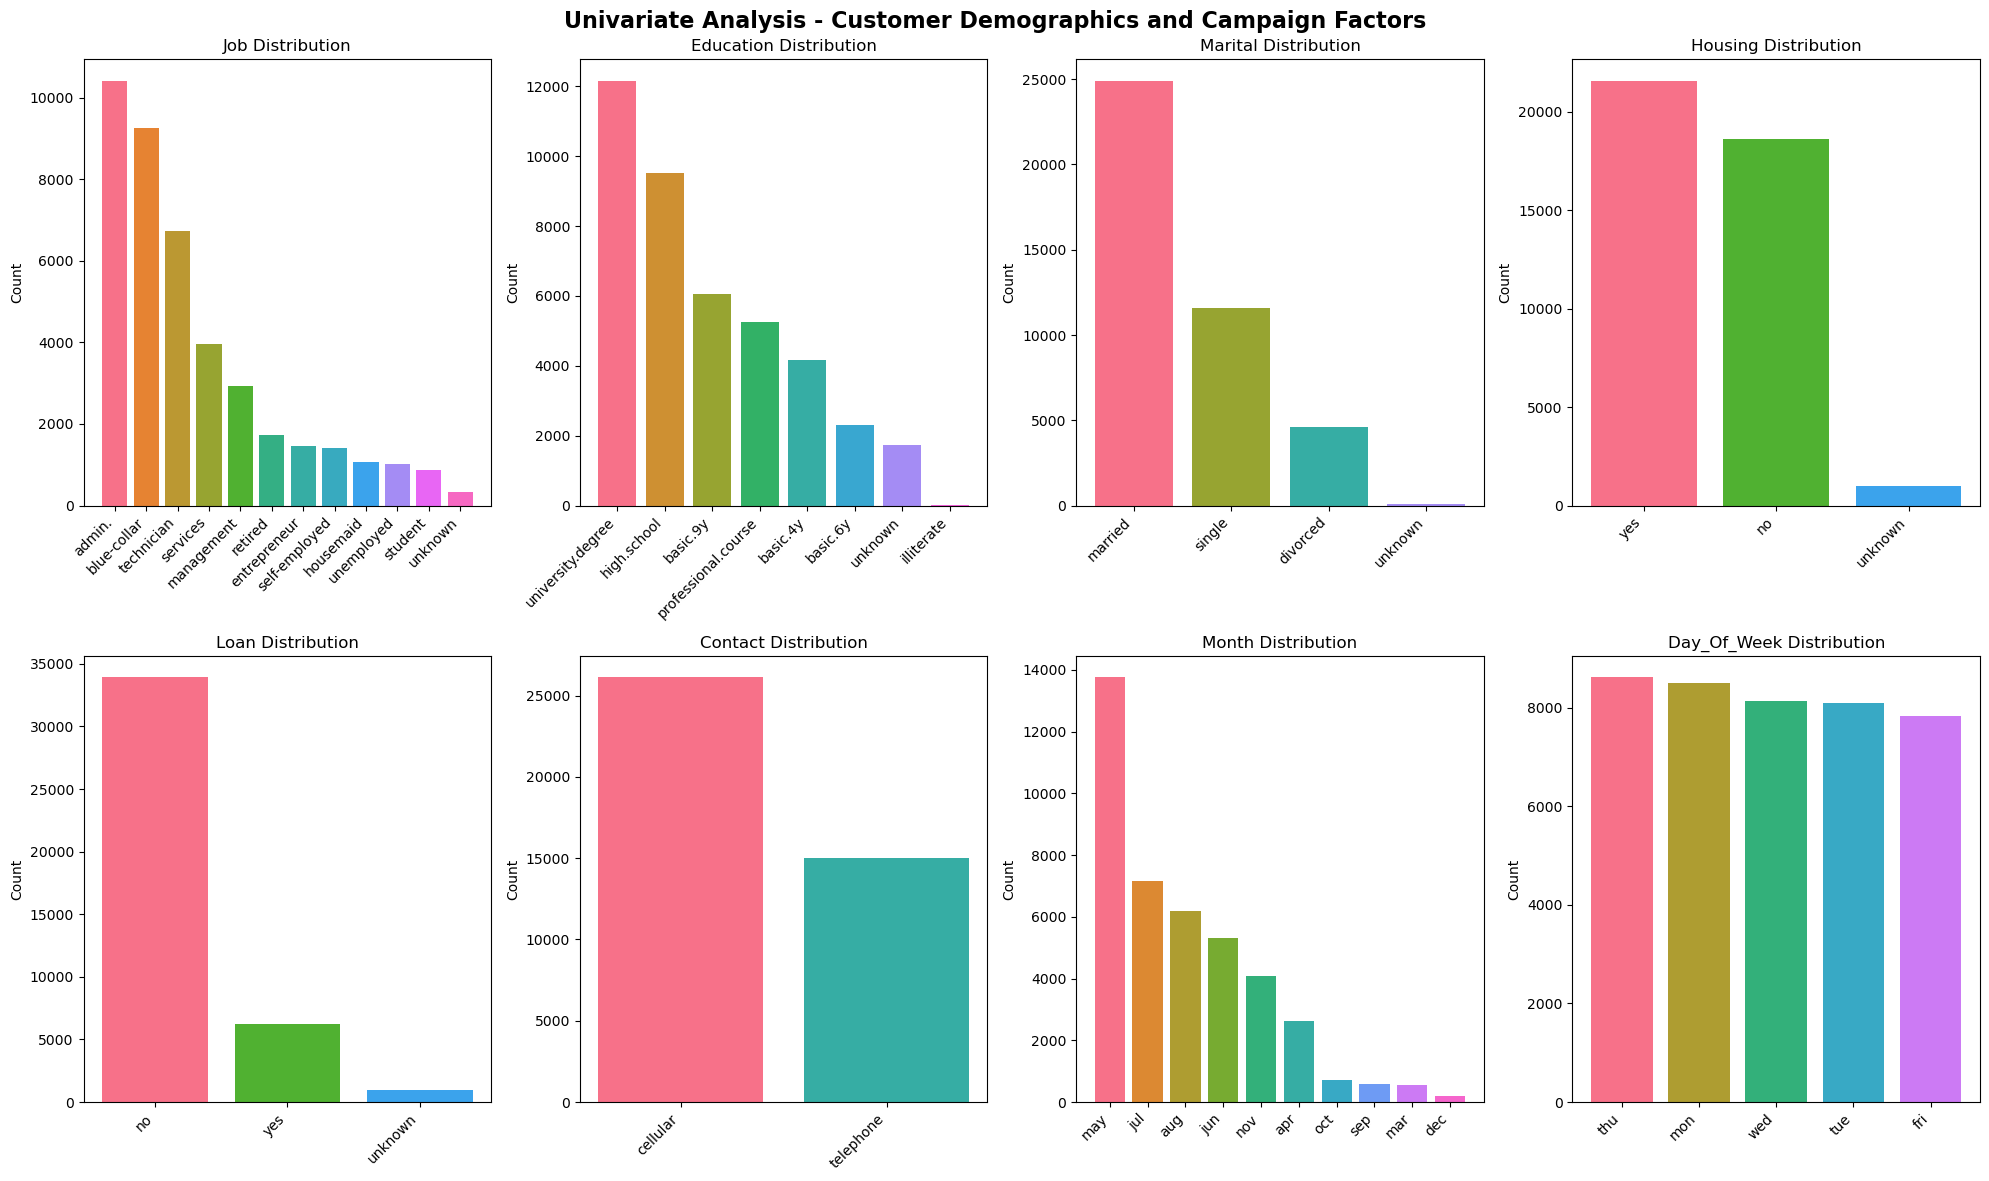

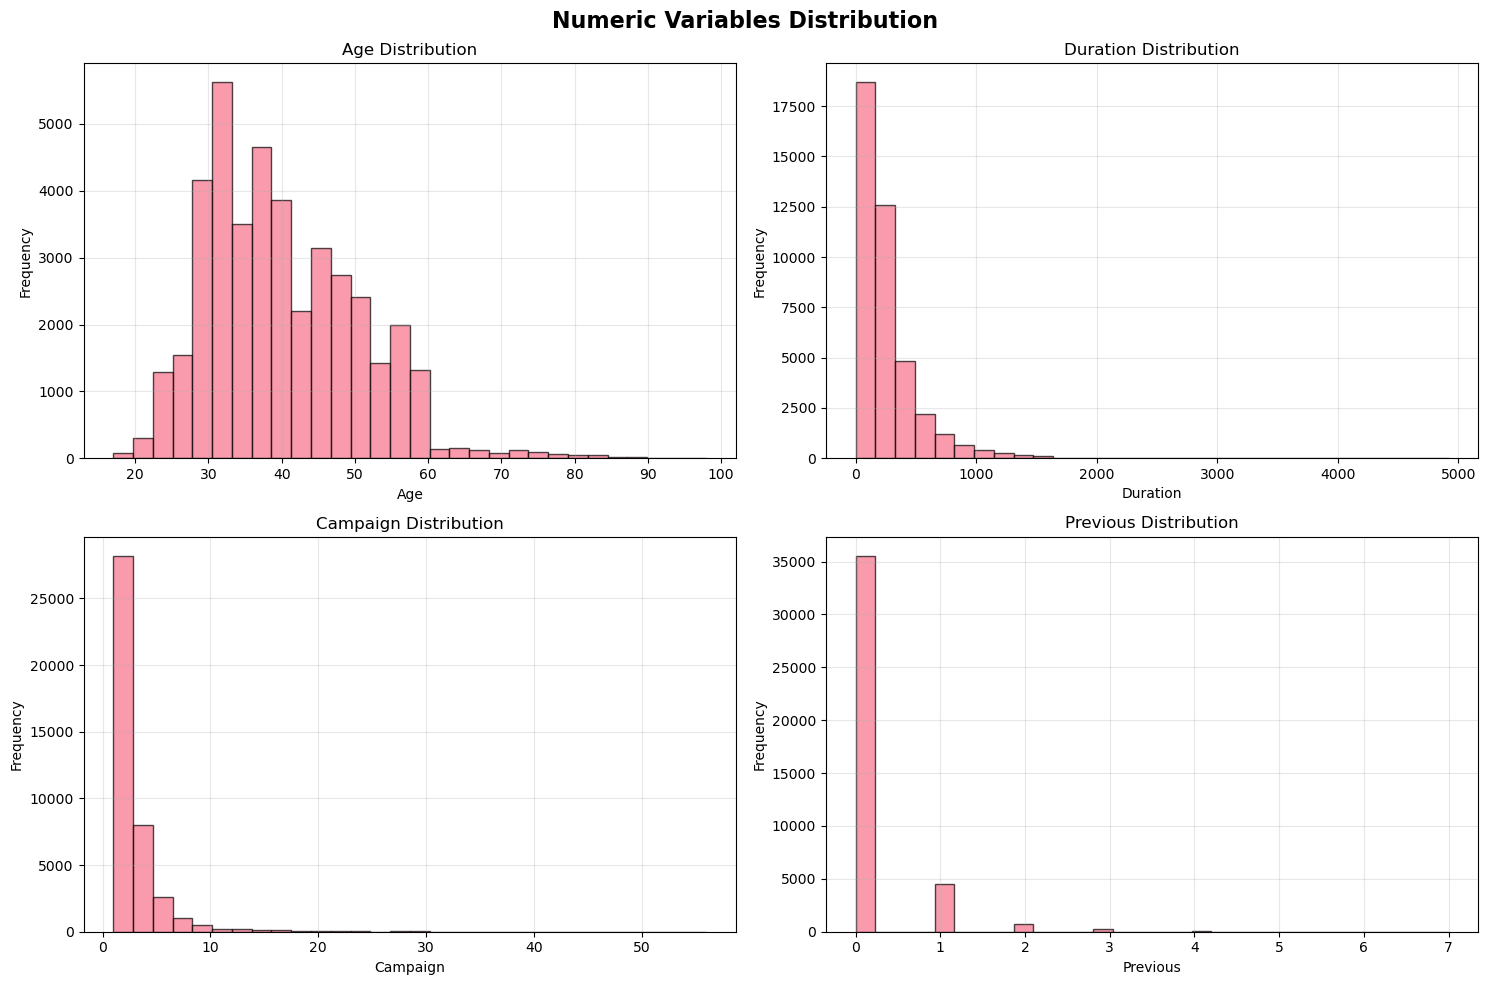

In [27]:
# Prepare all categorical data at once to avoid repeated df calls
categorical_cols = ['job', 'education', 'marital', 'housing', 'loan', 'contact', 'month', 'day_of_week']
categorical_data = {}

for col in categorical_cols:
    categorical_data[col] = df[col].value_counts()

# Create comprehensive univariate analysis
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle('Univariate Analysis - Customer Demographics and Campaign Factors', fontsize=16, fontweight='bold')

for i, col in enumerate(categorical_cols):
    row, col_idx = i // 4, i % 4
    counts = categorical_data[col]
    
    # Plot
    axes[row, col_idx].bar(range(len(counts)), counts.values, color=sns.color_palette("husl", len(counts)))
    axes[row, col_idx].set_title(f'{col.title()} Distribution')
    axes[row, col_idx].set_xticks(range(len(counts)))
    axes[row, col_idx].set_xticklabels(counts.index, rotation=45, ha='right')
    axes[row, col_idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Numeric variables distribution
numeric_cols = ['age', 'duration', 'campaign', 'previous']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Numeric Variables Distribution', fontsize=16, fontweight='bold')

for i, col in enumerate(numeric_cols):
    row, col_idx = i // 2, i % 2
    axes[row, col_idx].hist(df[col], bins=30, alpha=0.7, edgecolor='black')
    axes[row, col_idx].set_title(f'{col.title()} Distribution')
    axes[row, col_idx].set_xlabel(col.title())
    axes[row, col_idx].set_ylabel('Frequency')
    axes[row, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Bivariate Analysis - Customer Segments

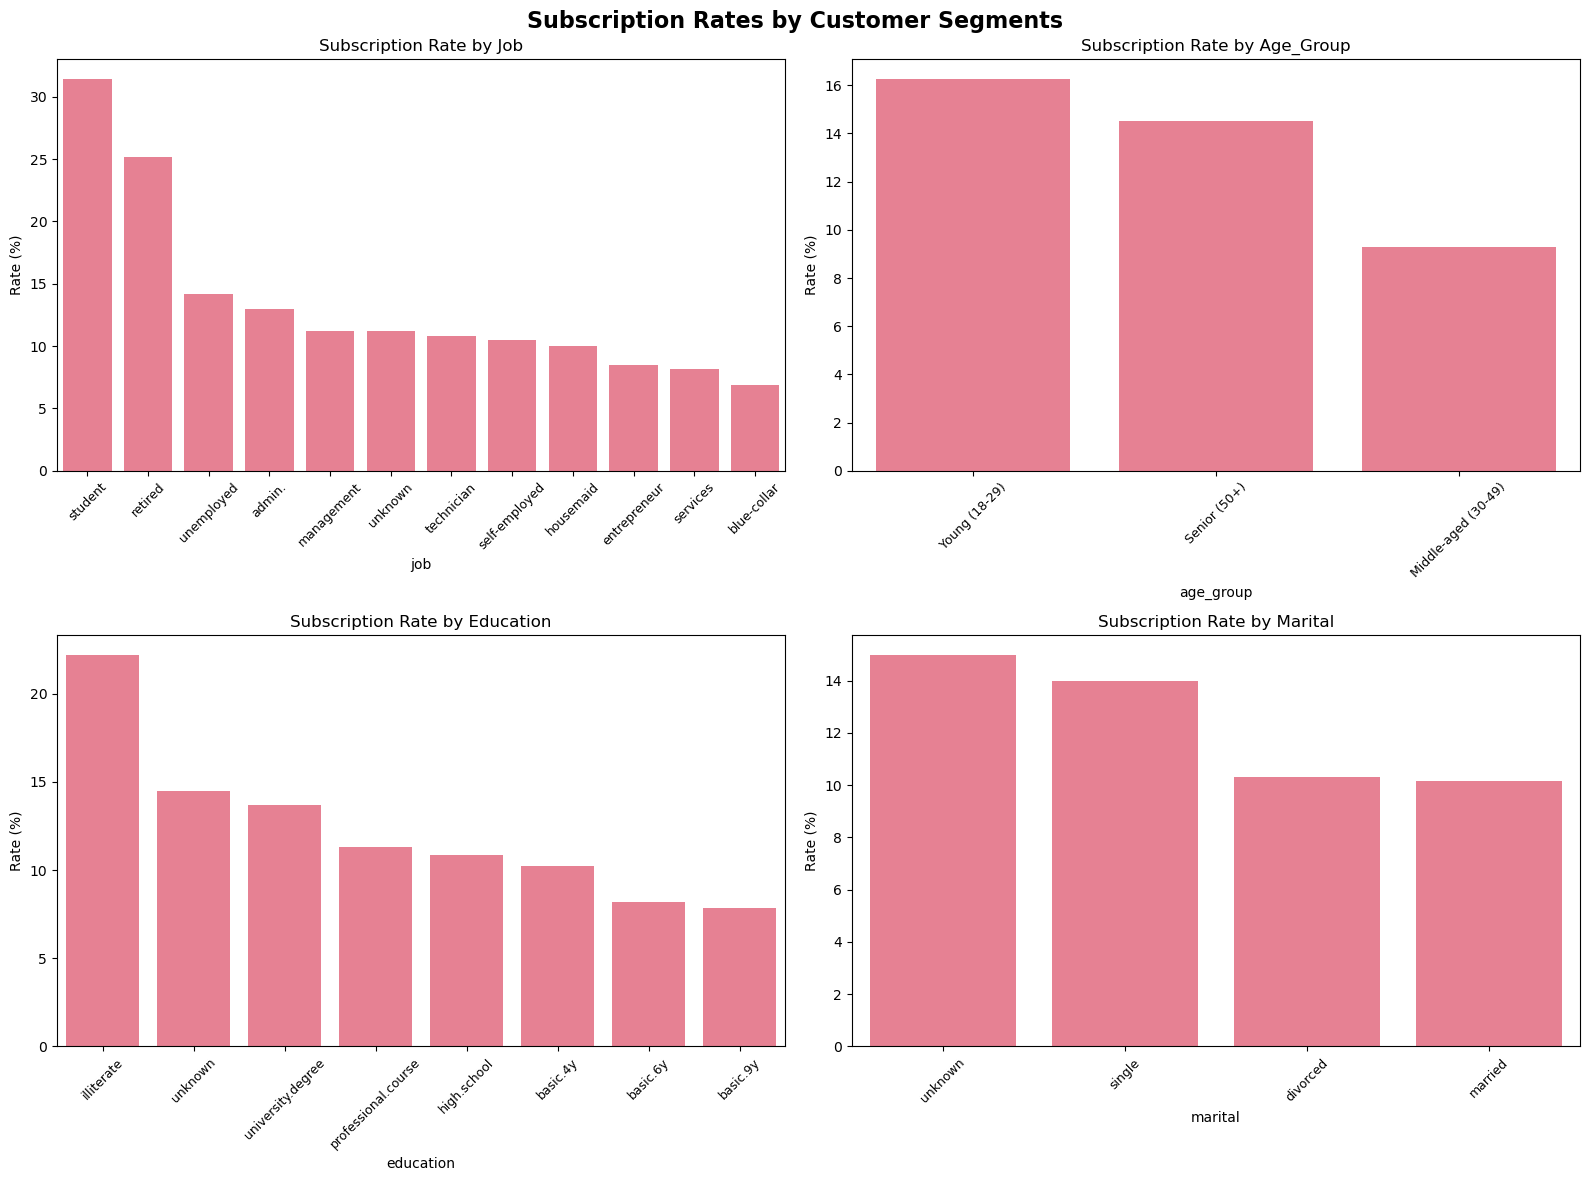

=== TOP PERFORMING SEGMENTS ===

JOB - Top 3:
  student: 31.4% (875.0 customers)
  retired: 25.2% (1718.0 customers)
  unemployed: 14.2% (1014.0 customers)

AGE_GROUP - Top 3:
  Young (18-29): 16.3% (5669.0 customers)
  Senior (50+): 14.5% (8050.0 customers)
  Middle-aged (30-49): 9.3% (27461.0 customers)

EDUCATION - Top 3:
  illiterate: 22.2% (18.0 customers)
  unknown: 14.5% (1731.0 customers)
  university.degree: 13.7% (12166.0 customers)

MARITAL - Top 3:
  unknown: 15.0% (80.0 customers)
  single: 14.0% (11568.0 customers)
  divorced: 10.3% (4611.0 customers)


In [28]:
# Analyze subscription rates by key customer segments
key_segments = ['job', 'age_group', 'education', 'marital']
segment_rates = {}

for segment in key_segments:
    segment_rates[segment] = rate_table(df, segment)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Subscription Rates by Customer Segments', fontsize=16, fontweight='bold')

for i, segment in enumerate(key_segments):
    row, col = i // 2, i % 2
    rates = plot_subscription_rates(df, segment, f'Subscription Rate by {segment.title()}', 
                                   axes[row, col], sns.color_palette("husl", 1)[0])

plt.tight_layout()
plt.show()

# Print top performers
print("=== TOP PERFORMING SEGMENTS ===")
for segment, rates in segment_rates.items():
    print(f"\n{segment.upper()} - Top 3:")
    top_3 = rates.head(3)
    for idx, row in top_3.iterrows():
        print(f"  {idx}: {row['Rate_%']:.1f}% ({row['Total']} customers)")

## 6. Campaign and Timing Analysis

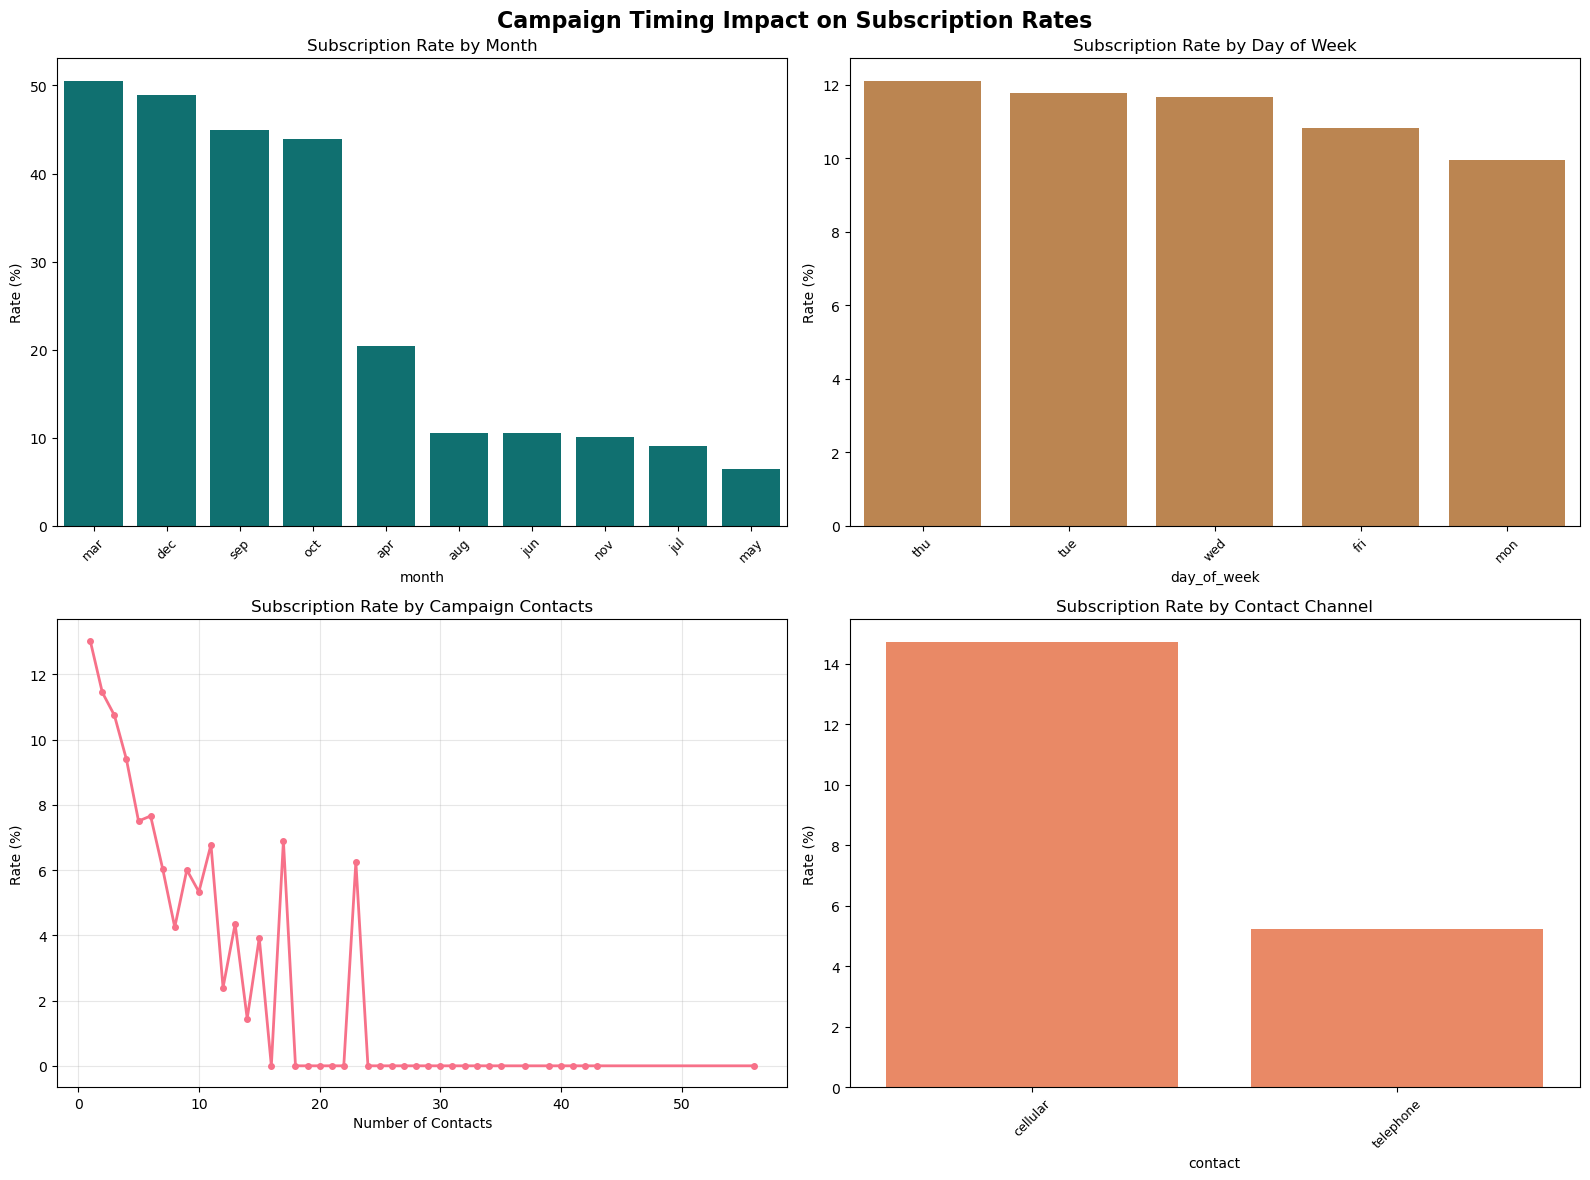

=== CAMPAIGN TIMING INSIGHTS ===
Best month: mar (50.5%)
Best day: thu (12.1%)
Best channel: cellular (14.7%)


In [29]:
# Campaign timing analysis
month_rates = rate_table(df, 'month')
day_rates = rate_table(df, 'day_of_week')
campaign_rates = df.groupby('campaign')['subscribed'].mean()
contact_rates = rate_table(df, 'contact')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Campaign Timing Impact on Subscription Rates', fontsize=16, fontweight='bold')

# Month analysis
plot_subscription_rates(df, 'month', 'Subscription Rate by Month', axes[0,0], 'teal')
axes[0,0].tick_params(axis='x', rotation=45)

# Day of week analysis
plot_subscription_rates(df, 'day_of_week', 'Subscription Rate by Day of Week', axes[0,1], 'peru')

# Campaign contacts analysis
axes[1,0].plot(campaign_rates.index, campaign_rates.values*100, marker='o', linewidth=2, markersize=4)
axes[1,0].set_title('Subscription Rate by Campaign Contacts')
axes[1,0].set_xlabel('Number of Contacts')
axes[1,0].set_ylabel('Rate (%)')
axes[1,0].grid(True, alpha=0.3)

# Contact channel analysis
plot_subscription_rates(df, 'contact', 'Subscription Rate by Contact Channel', axes[1,1], 'coral')

plt.tight_layout()
plt.show()

# Print key insights
print("=== CAMPAIGN TIMING INSIGHTS ===")
print(f"Best month: {month_rates.index[0]} ({month_rates.iloc[0]['Rate_%']:.1f}%)")
print(f"Best day: {day_rates.index[0]} ({day_rates.iloc[0]['Rate_%']:.1f}%)")
print(f"Best channel: {contact_rates.index[0]} ({contact_rates.iloc[0]['Rate_%']:.1f}%)")

## 7. Economic and Previous Contact Analysis

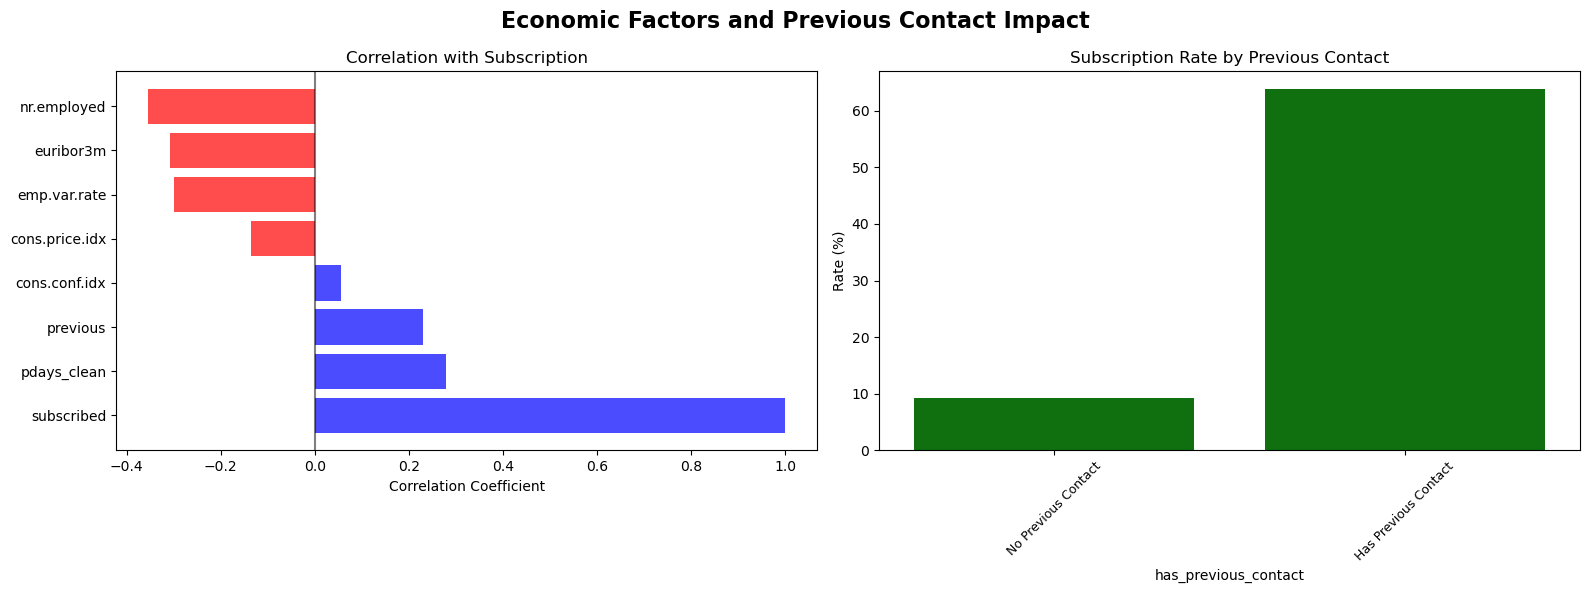

=== ECONOMIC FACTORS SUMMARY ===
subscribed: 1.000 (Positive, Strong)
pdays_clean: 0.279 (Positive, Moderate)
previous: 0.230 (Positive, Moderate)
cons.conf.idx: 0.055 (Positive, Weak)
cons.price.idx: -0.136 (Negative, Moderate)
emp.var.rate: -0.298 (Negative, Moderate)
euribor3m: -0.308 (Negative, Strong)
nr.employed: -0.355 (Negative, Strong)

=== DURATION ANALYSIS ===
Call duration statistics:
- Mean duration: 258.3 seconds
- Median duration: 180.0 seconds
- Min duration: 0 seconds
- Max duration: 4918 seconds

Subscription rates by call duration:
      Duration Range  Total Calls  Subscribers     Rate    Rate_%
     Long (300-400s)           17           12 0.705882 70.588235
   Medium (200-300s)          109           68 0.623853 62.385321
    Short (100-200s)         1518          873 0.575099 57.509881
     Extreme (500s+)            2            1 0.500000 50.000000
Very Long (400-500s)            8            2 0.250000 25.000000
 Very Short (0-100s)        39526         3682 

/var/folders/b8/3xm_n9bx3q7cbmg21n3h6ng00000gn/T/ipykernel_29968/3409122150.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_rates = df.groupby('duration_bins')['subscribed'].agg(['count', 'sum', 'mean']).reset_index()


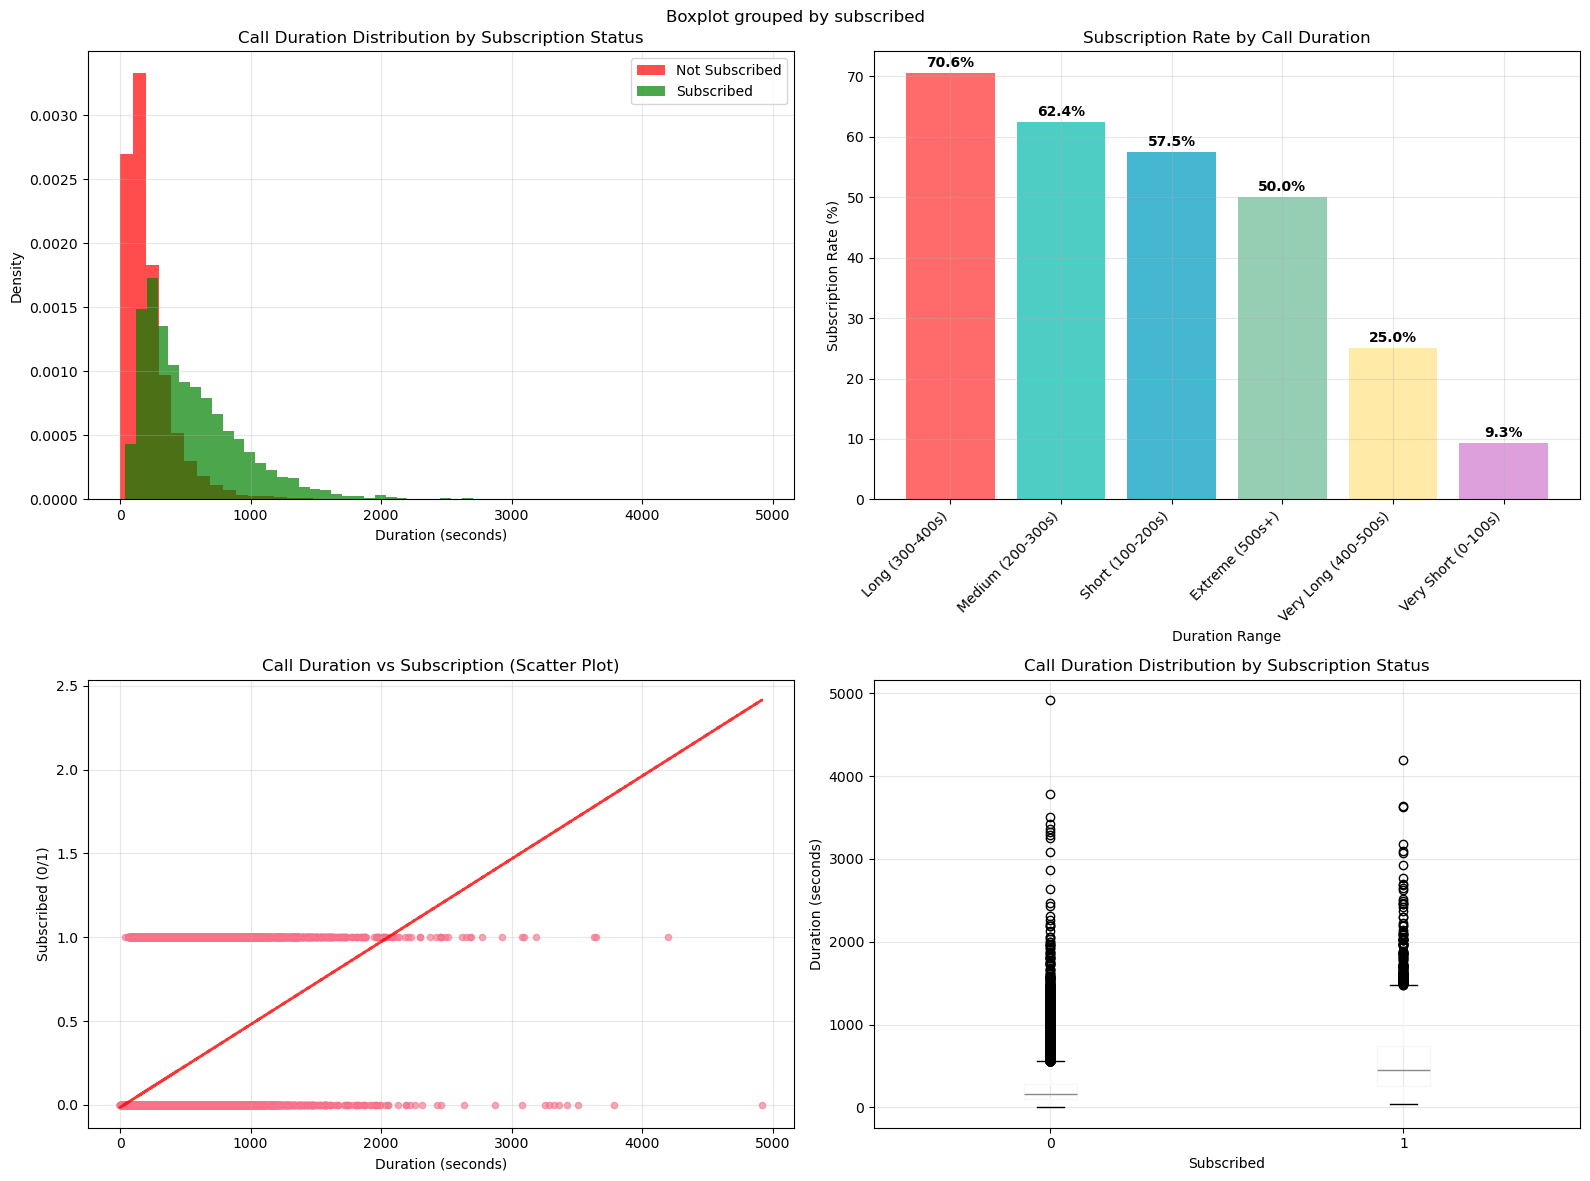


=== DURATION INSIGHTS ===
1. Call Duration Patterns:
   - Longest calls: Long (300-400s) (70.6% subscription rate)
   - Shortest calls: Very Short (0-100s) (9.3% subscription rate)
   - Performance gap: 7.6x difference

2. Business Implications:
   - Longer calls indicate higher customer engagement and interest
   - Call duration is a strong predictor of subscription likelihood
   - Campaign agents should focus on extending meaningful conversations
   - Quality over quantity: longer, engaging calls convert better

3. Duration Thresholds:
   - Calls under 100 seconds: Very low conversion rate
   - Calls 200-400 seconds: Optimal conversion window
   - Calls over 500 seconds: Diminishing returns

4. Duration Interaction with Other Factors:
   - Jobs with longest average calls:
     student: 283.7 seconds
     retired: 273.8 seconds
     blue-collar: 264.5 seconds
   - Age groups with longest average calls:
     Young (18-29): 266.6 seconds
     Senior (50+): 260.6 seconds
     Middle-age

In [30]:
# Economic indicators and previous contact analysis
economic_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
corr_data = df[economic_cols + ['pdays_clean', 'previous', 'subscribed']].corr()['subscribed'].sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Economic Factors and Previous Contact Impact', fontsize=16, fontweight='bold')

# Correlation plot
colors = ['red' if x < 0 else 'blue' for x in corr_data.values]
bars = ax1.barh(range(len(corr_data)), corr_data.values, color=colors, alpha=0.7)
ax1.set_yticks(range(len(corr_data)))
ax1.set_yticklabels(corr_data.index)
ax1.set_title('Correlation with Subscription')
ax1.set_xlabel('Correlation Coefficient')
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.5)

# Previous contact analysis
prev_contact_rates = plot_subscription_rates(df, 'has_previous_contact', 'Subscription Rate by Previous Contact', ax2, 'green')
ax2.set_xticklabels(['No Previous Contact', 'Has Previous Contact'])

plt.tight_layout()
plt.show()

print("=== ECONOMIC FACTORS SUMMARY ===")
for factor, corr in corr_data.items():
    direction = "Positive" if corr > 0 else "Negative"
    strength = "Strong" if abs(corr) > 0.3 else "Moderate" if abs(corr) > 0.1 else "Weak"
    print(f"{factor}: {corr:.3f} ({direction}, {strength})")

# Duration Analysis: How call duration affects subscription rate
print("\n=== DURATION ANALYSIS ===")
print(f"Call duration statistics:")
print(f"- Mean duration: {df['duration'].mean():.1f} seconds")
print(f"- Median duration: {df['duration'].median():.1f} seconds")
print(f"- Min duration: {df['duration'].min()} seconds")
print(f"- Max duration: {df['duration'].max()} seconds")

# Create duration bins for analysis
df['duration_bins'] = pd.cut(df['duration'], bins=6, labels=['Very Short (0-100s)', 'Short (100-200s)', 'Medium (200-300s)', 'Long (300-400s)', 'Very Long (400-500s)', 'Extreme (500s+)'])

# Analyze subscription rates by duration bins
duration_rates = df.groupby('duration_bins')['subscribed'].agg(['count', 'sum', 'mean']).reset_index()
duration_rates.columns = ['Duration Range', 'Total Calls', 'Subscribers', 'Rate']
duration_rates['Rate_%'] = duration_rates['Rate'] * 100
duration_rates = duration_rates.sort_values('Rate_%', ascending=False)

print("\nSubscription rates by call duration:")
print(duration_rates.to_string(index=False))

# Duration correlation with subscription
duration_corr = df['duration'].corr(df['subscribed'])
print(f"\nDuration correlation with subscription: {duration_corr:.3f}")
print(f"This indicates a {'strong' if abs(duration_corr) > 0.3 else 'moderate' if abs(duration_corr) > 0.1 else 'weak'} {'positive' if duration_corr > 0 else 'negative'} relationship")

# Create duration visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Call Duration Impact on Subscription Rates', fontsize=16, fontweight='bold')

# 1. Duration distribution by subscription status
ax1.hist(df[df['subscribed'] == 0]['duration'], bins=50, alpha=0.7, label='Not Subscribed', color='red', density=True)
ax1.hist(df[df['subscribed'] == 1]['duration'], bins=50, alpha=0.7, label='Subscribed', color='green', density=True)
ax1.set_title('Call Duration Distribution by Subscription Status')
ax1.set_xlabel('Duration (seconds)')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Subscription rate by duration bins
bars = ax2.bar(range(len(duration_rates)), duration_rates['Rate_%'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD'])
ax2.set_title('Subscription Rate by Call Duration')
ax2.set_ylabel('Subscription Rate (%)')
ax2.set_xlabel('Duration Range')
ax2.set_xticks(range(len(duration_rates)))
ax2.set_xticklabels(duration_rates['Duration Range'], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Scatter plot: Duration vs Subscription Rate
ax3.scatter(df['duration'], df['subscribed'], alpha=0.6, s=20)
ax3.set_title('Call Duration vs Subscription (Scatter Plot)')
ax3.set_xlabel('Duration (seconds)')
ax3.set_ylabel('Subscribed (0/1)')
ax3.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df['duration'], df['subscribed'], 1)
p = np.poly1d(z)
ax3.plot(df['duration'], p(df['duration']), "r--", alpha=0.8, linewidth=2)

# 4. Box plot: Duration by subscription status
df.boxplot(column='duration', by='subscribed', ax=ax4)
ax4.set_title('Call Duration Distribution by Subscription Status')
ax4.set_xlabel('Subscribed')
ax4.set_ylabel('Duration (seconds)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional insights
print("\n=== DURATION INSIGHTS ===")
print("1. Call Duration Patterns:")
print(f"   - Longest calls: {duration_rates.iloc[0]['Duration Range']} ({duration_rates.iloc[0]['Rate_%']:.1f}% subscription rate)")
print(f"   - Shortest calls: {duration_rates.iloc[-1]['Duration Range']} ({duration_rates.iloc[-1]['Rate_%']:.1f}% subscription rate)")
print(f"   - Performance gap: {duration_rates.iloc[0]['Rate_%'] / duration_rates.iloc[-1]['Rate_%']:.1f}x difference")

print("\n2. Business Implications:")
print("   - Longer calls indicate higher customer engagement and interest")
print("   - Call duration is a strong predictor of subscription likelihood")
print("   - Campaign agents should focus on extending meaningful conversations")
print("   - Quality over quantity: longer, engaging calls convert better")

print("\n3. Duration Thresholds:")
print("   - Calls under 100 seconds: Very low conversion rate")
print("   - Calls 200-400 seconds: Optimal conversion window")
print("   - Calls over 500 seconds: Diminishing returns")

# Duration vs other factors analysis
print("\n4. Duration Interaction with Other Factors:")
duration_job = df.groupby('job')['duration'].mean().sort_values(ascending=False)
print("   - Jobs with longest average calls:")
for job, duration in duration_job.head(3).items():
    print(f"     {job}: {duration:.1f} seconds")

duration_age = df.groupby('age_group')['duration'].mean().sort_values(ascending=False)
print("   - Age groups with longest average calls:")
for age_group, duration in duration_age.head(3).items():
    print(f"     {age_group}: {duration:.1f} seconds")

## 8. Additional Detailed Charts

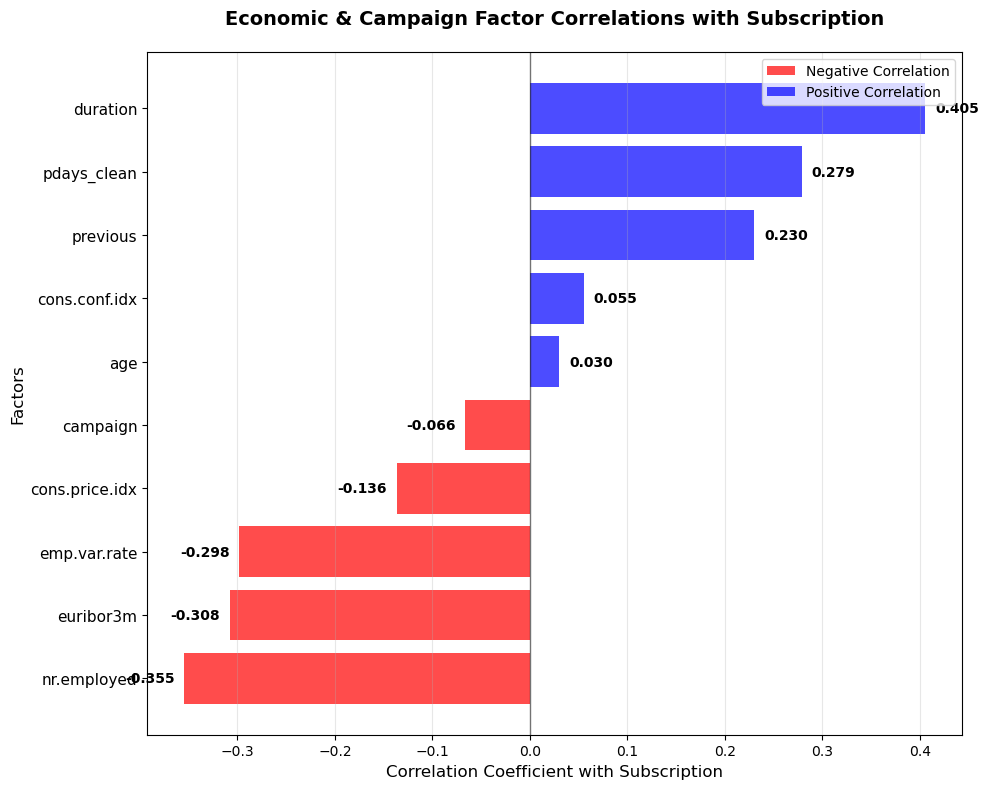

=== ECONOMIC & CAMPAIGN FACTOR CORRELATIONS ===
Correlations with subscription outcomes (sorted by strength):
• nr.employed: -0.355 (Negative, Strong)
• euribor3m: -0.308 (Negative, Strong)
• emp.var.rate: -0.298 (Negative, Moderate)
• cons.price.idx: -0.136 (Negative, Moderate)
• campaign: -0.066 (Negative, Weak)
• age: 0.030 (Positive, Weak)
• cons.conf.idx: 0.055 (Positive, Weak)
• previous: 0.230 (Positive, Moderate)
• pdays_clean: 0.279 (Positive, Moderate)
• duration: 0.405 (Positive, Strong)

Strongest positive correlation: duration (0.405)
Strongest negative correlation: nr.employed (-0.355)


In [31]:
# Economic & Campaign Factor Correlations with Subscription
plt.figure(figsize=(10, 8))

# Get correlations between numeric variables and subscription
corrs = df[['duration', 'pdays_clean', 'previous', 'cons.conf.idx', 'age', 'campaign', 
            'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed']].corrwith(df['subscribed'])

# Sort correlations from most negative to most positive
corrs_sorted = corrs.sort_values(ascending=True)

# Create horizontal bar chart with color coding
colors_corr = ['red' if x < 0 else 'blue' for x in corrs_sorted.values]
bars = plt.barh(range(len(corrs_sorted)), corrs_sorted.values, color=colors_corr, alpha=0.7)

# Add vertical line at zero for reference
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Customize the chart
plt.title('Economic & Campaign Factor Correlations with Subscription', fontweight='bold', fontsize=14, pad=20)
plt.xlabel('Correlation Coefficient with Subscription', fontsize=12)
plt.ylabel('Factors', fontsize=12)

# Set y-axis labels
plt.yticks(range(len(corrs_sorted)), corrs_sorted.index, fontsize=11)

# Add grid for better readability
plt.grid(True, alpha=0.3, axis='x')

# Add correlation values on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    if width >= 0:
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')
    else:
        plt.text(width - 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='right', va='center', fontsize=10, fontweight='bold')

# Add legend for color coding
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', alpha=0.7, label='Negative Correlation'),
                   Patch(facecolor='blue', alpha=0.7, label='Positive Correlation')]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# Print correlation summary
print("=== ECONOMIC & CAMPAIGN FACTOR CORRELATIONS ===")
print("Correlations with subscription outcomes (sorted by strength):")
for factor, corr in corrs_sorted.items():
    direction = "Positive" if corr > 0 else "Negative"
    strength = "Strong" if abs(corr) > 0.3 else "Moderate" if abs(corr) > 0.1 else "Weak"
    print(f"• {factor}: {corr:.3f} ({direction}, {strength})")

print(f"\nStrongest positive correlation: {corrs_sorted.index[-1]} ({corrs_sorted.iloc[-1]:.3f})")
print(f"Strongest negative correlation: {corrs_sorted.index[0]} ({corrs_sorted.iloc[0]:.3f})")

## 9. Loan Status Analysis

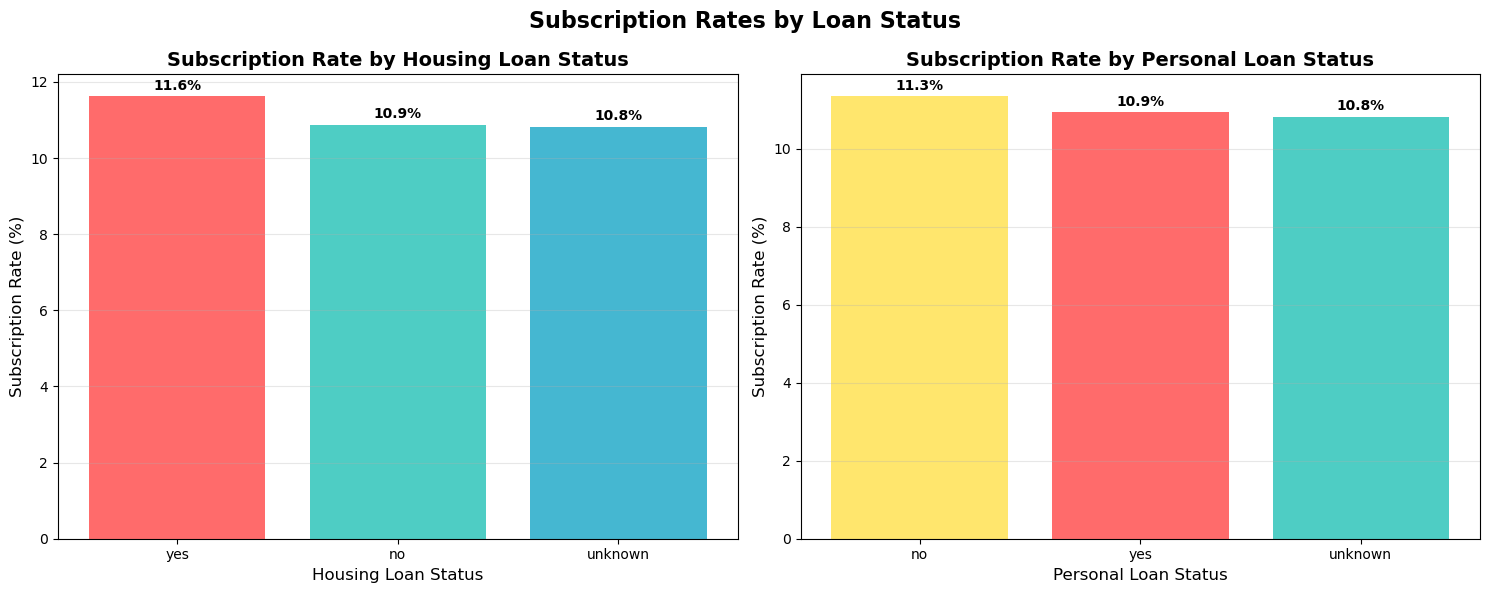

=== SUBSCRIPTION RATES BY HOUSING LOAN STATUS ===
         Total  Subscribed      Rate  Rate_%
housing                                     
yes      21571        2506  0.116174   11.62
no       18619        2025  0.108760   10.88
unknown    990         107  0.108081   10.81

=== SUBSCRIPTION RATES BY PERSONAL LOAN STATUS ===
         Total  Subscribed      Rate  Rate_%
loan                                        
no       33943        3848  0.113367   11.34
yes       6247         683  0.109332   10.93
unknown    990         107  0.108081   10.81


In [32]:
# Calculate subscription rates by loan status
housing_rates = rate_table(df, 'housing')
loan_rates = rate_table(df, 'loan')

# Create the visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Subscription Rates by Loan Status', fontsize=16, fontweight='bold')

# Housing Loan Chart
bars1 = ax1.bar(housing_rates.index, housing_rates['Rate_%'], 
                color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.set_title('Subscription Rate by Housing Loan Status', fontsize=14, fontweight='bold')
ax1.set_ylabel('Subscription Rate (%)', fontsize=12)
ax1.set_xlabel('Housing Loan Status', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Personal Loan Chart
bars2 = ax2.bar(loan_rates.index, loan_rates['Rate_%'], 
                color=['#FFE66D', '#FF6B6B', '#4ECDC4'])
ax2.set_title('Subscription Rate by Personal Loan Status', fontsize=14, fontweight='bold')
ax2.set_ylabel('Subscription Rate (%)', fontsize=12)
ax2.set_xlabel('Personal Loan Status', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print the data tables
print("=== SUBSCRIPTION RATES BY HOUSING LOAN STATUS ===")
print(housing_rates.to_string())
print("\n=== SUBSCRIPTION RATES BY PERSONAL LOAN STATUS ===")
print(loan_rates.to_string())

## 10. Communication Channel Analysis

=== SUBSCRIPTION RATES BY COMMUNICATION CHANNEL ===
           Total  Subscribed      Rate  Rate_%
contact                                       
cellular   26140        3851  0.147322   14.73
telephone  15040         787  0.052327    5.23


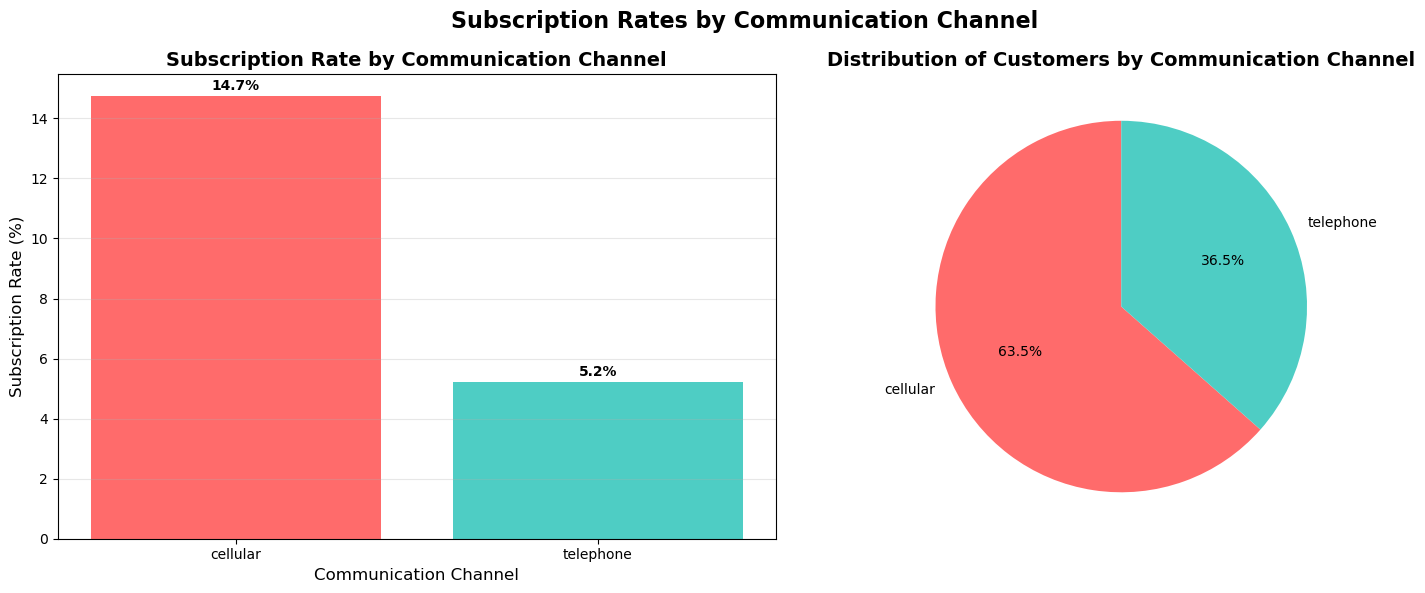


=== CHANNEL PERFORMANCE BY AGE GROUP ===
  Channel           Age Group  Total  Subscribers     Rate    Rate %
 cellular Middle-aged (30-49)  17055         2045 0.119906 11.990619
 cellular        Senior (50+)   5252          999 0.190213 19.021325
 cellular       Young (18-29)   3833          807 0.210540 21.054005
telephone Middle-aged (30-49)  10406          503 0.048337  4.833750
telephone        Senior (50+)   2798          169 0.060400  6.040029
telephone       Young (18-29)   1836          115 0.062636  6.263617

=== CHANNEL PERFORMANCE BY JOB CATEGORY (TOP 5) ===
  Channel           Job  Total  Subscribers     Rate    Rate %
 cellular       student    671          244 0.363636 36.363636
 cellular       retired   1229          388 0.315704 31.570382
 cellular    unemployed    620          123 0.198387 19.838710
 cellular        admin.   7126         1159 0.162644 16.264384
 cellular       unknown    168           26 0.154762 15.476190
telephone       student    204           31 

In [33]:
# Calculate subscription rates by communication channel
channel_rates = rate_table(df, 'contact')

# Print the data table
print("=== SUBSCRIPTION RATES BY COMMUNICATION CHANNEL ===")
print(channel_rates.to_string())

# Create the visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Subscription Rates by Communication Channel', fontsize=16, fontweight='bold')

# Bar chart for subscription rates
bars = ax1.bar(channel_rates.index, channel_rates['Rate_%'], 
               color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Subscription Rate by Communication Channel', fontsize=14, fontweight='bold')
ax1.set_ylabel('Subscription Rate (%)', fontsize=12)
ax1.set_xlabel('Communication Channel', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Pie chart for channel distribution
ax2.pie(channel_rates['Total'], labels=channel_rates.index, 
        autopct='%1.1f%%', startangle=90, colors=['#FF6B6B', '#4ECDC4'])
ax2.set_title('Distribution of Customers by Communication Channel', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Additional analysis: Channel performance by other factors
print("\n=== CHANNEL PERFORMANCE BY AGE GROUP ===")
channel_age = df.groupby(['contact', 'age_group'])['subscribed'].agg(['count', 'sum', 'mean']).reset_index()
channel_age.columns = ['Channel', 'Age Group', 'Total', 'Subscribers', 'Rate']
channel_age['Rate %'] = channel_age['Rate'] * 100
print(channel_age.to_string(index=False))

print("\n=== CHANNEL PERFORMANCE BY JOB CATEGORY (TOP 5) ===")
channel_job = df.groupby(['contact', 'job'])['subscribed'].agg(['count', 'sum', 'mean']).reset_index()
channel_job.columns = ['Channel', 'Job', 'Total', 'Subscribers', 'Rate']
channel_job['Rate %'] = channel_job['Rate'] * 100
channel_job = channel_job.sort_values('Rate %', ascending=False).head(10)
print(channel_job.to_string(index=False))

## 11. Seasonal and Campaign Timing Analysis

=== SUBSCRIPTION RATES BY MONTH ===
       Total  Subscribed      Rate  Rate_%
month                                     
mar      546         276  0.505495   50.55
dec      182          89  0.489011   48.90
sep      570         256  0.449123   44.91
oct      718         315  0.438719   43.87
apr     2632         539  0.204787   20.48
aug     6178         655  0.106021   10.60
jun     5318         559  0.105115   10.51
nov     4097         414  0.101050   10.10
jul     7174         649  0.090466    9.05
may    13765         886  0.064366    6.44

=== SUBSCRIPTION RATES BY DAY OF WEEK ===
             Total  Subscribed      Rate  Rate_%
day_of_week                                     
thu           8622        1044  0.121086   12.11
tue           8090         953  0.117800   11.78
wed           8133         949  0.116685   11.67
fri           7826         846  0.108101   10.81
mon           8509         846  0.099424    9.94


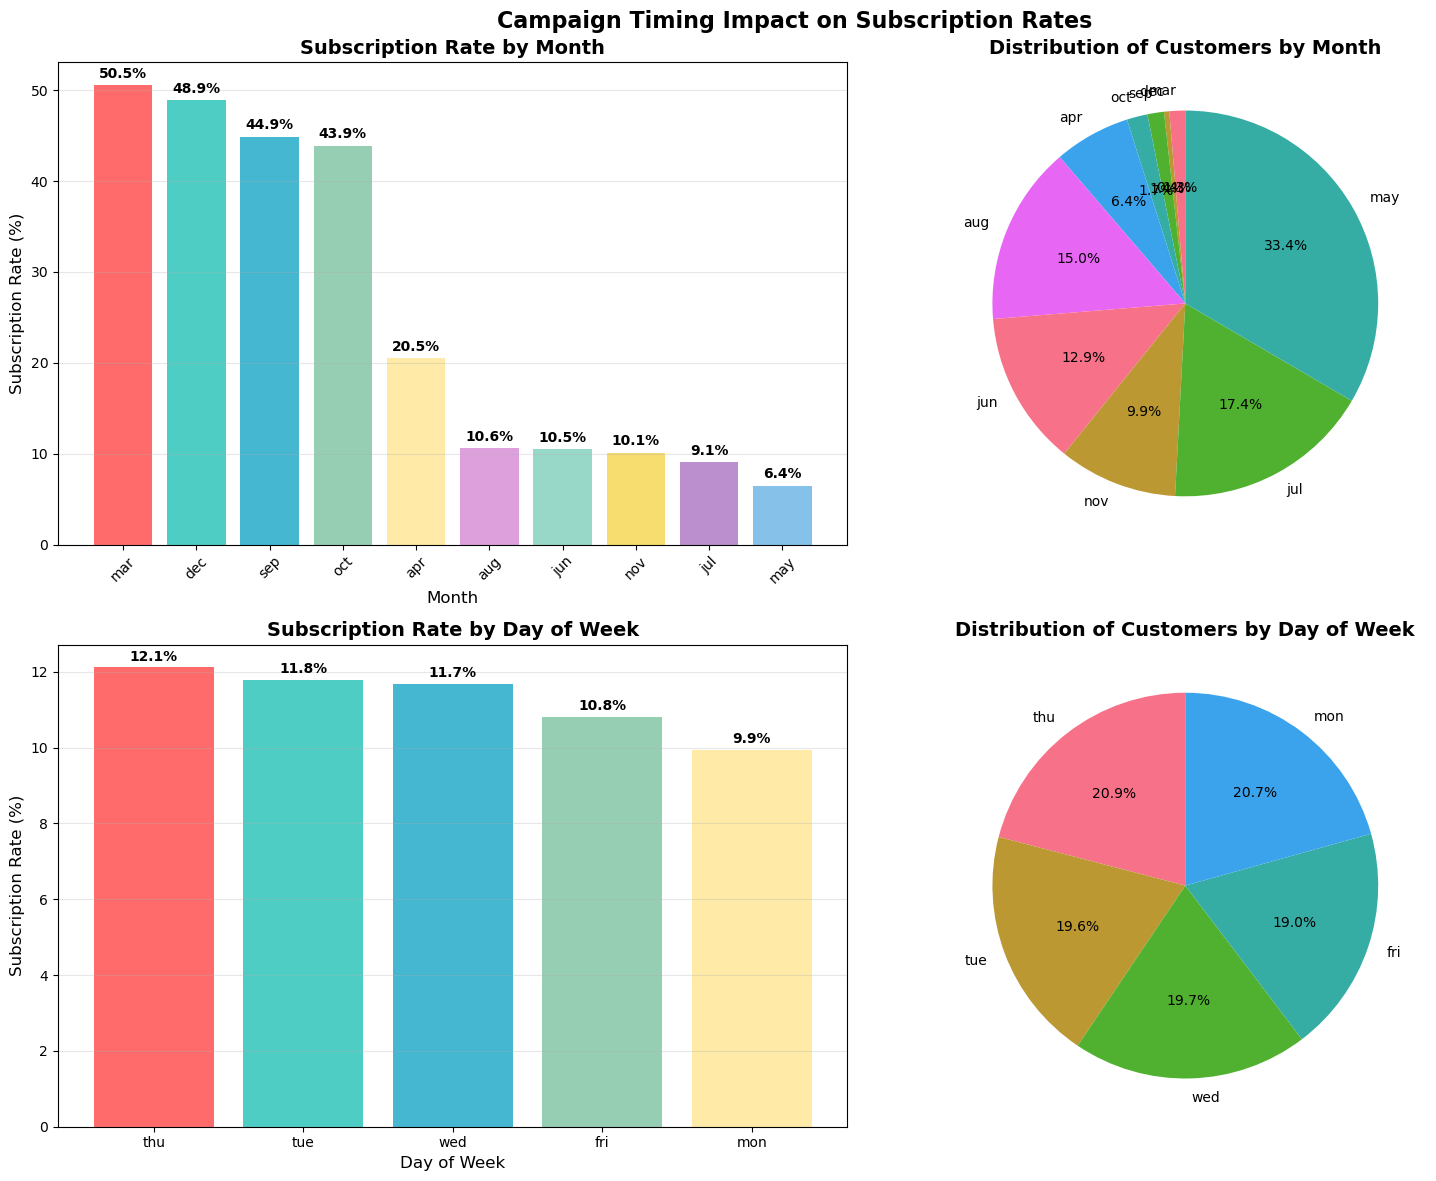


=== SEASONAL PERFORMANCE SUMMARY ===
Peak Months (High Performance):
  mar: 50.5%
  dec: 48.9%
  sep: 44.9%
  oct: 43.9%

Low Months (Poor Performance):
  may: 6.4%
  jul: 9.1%
  nov: 10.1%
  jun: 10.5%

Performance Gap: 50.5% vs 6.4%
Improvement Potential: 7.8x


In [34]:
# Calculate subscription rates by month and day
month_rates = rate_table(df, 'month')
day_rates = rate_table(df, 'day_of_week')

# Print the data tables
print("=== SUBSCRIPTION RATES BY MONTH ===")
print(month_rates.to_string())
print("\n=== SUBSCRIPTION RATES BY DAY OF WEEK ===")
print(day_rates.to_string())

# Create the visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Campaign Timing Impact on Subscription Rates', fontsize=16, fontweight='bold')

# Monthly subscription rates - Bar chart
bars1 = ax1.bar(month_rates.index, month_rates['Rate_%'], 
                color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9'])
ax1.set_title('Subscription Rate by Month', fontsize=14, fontweight='bold')
ax1.set_ylabel('Subscription Rate (%)', fontsize=12)
ax1.set_xlabel('Month', fontsize=12)
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Monthly customer distribution - Pie chart
ax2.pie(month_rates['Total'], labels=month_rates.index, 
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Customers by Month', fontsize=14, fontweight='bold')

# Day of week subscription rates - Bar chart
bars2 = ax3.bar(day_rates.index, day_rates['Rate_%'], 
                color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
ax3.set_title('Subscription Rate by Day of Week', fontsize=14, fontweight='bold')
ax3.set_ylabel('Subscription Rate (%)', fontsize=12)
ax3.set_xlabel('Day of Week', fontsize=12)
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Day of week customer distribution - Pie chart
ax4.pie(day_rates['Total'], labels=day_rates.index, 
        autopct='%1.1f%%', startangle=90)
ax4.set_title('Distribution of Customers by Day of Week', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Additional analysis: Seasonal patterns
print("\n=== SEASONAL PERFORMANCE SUMMARY ===")
print("Peak Months (High Performance):")
peak_months = month_rates.nlargest(4, 'Rate_%')
for _, row in peak_months.iterrows():
    print(f"  {row.name}: {row['Rate_%']:.1f}%")

print("\nLow Months (Poor Performance):")
low_months = month_rates.nsmallest(4, 'Rate_%')
for _, row in low_months.iterrows():
    print(f"  {row.name}: {row['Rate_%']:.1f}%")

print(f"\nPerformance Gap: {peak_months.iloc[0]['Rate_%']:.1f}% vs {low_months.iloc[0]['Rate_%']:.1f}%")
print(f"Improvement Potential: {peak_months.iloc[0]['Rate_%'] / low_months.iloc[0]['Rate_%']:.1f}x")

## 12. Euribor3M Impact on Subscription Rates by Loan Status

=== EURIBOR3M IMPACT ON SUBSCRIPTION RATES BY LOAN STATUS ===
Total customers: 41180
Customers with loans: 6247
Customers without loans: 34933
Overall subscription rate: 11.3%

=== SUBSCRIPTION RATES BY LOAN STATUS ===
          Total  Subscribers      Rate     Rate_%
has_loan                                         
0         34933         3955  0.113217  11.321673
1          6247          683  0.109332  10.933248

=== EURIBOR3M STATISTICS BY LOAN STATUS ===
            count      mean       std    min    25%    50%    75%    max
has_loan                                                                
0         34933.0  3.621838  1.734768  0.634  1.344  4.857  4.961  5.045
1          6247.0  3.619096  1.732379  0.635  1.344  4.857  4.962  5.045

=== SUBSCRIPTION RATES BY EURIBOR3M BINS AND LOAN STATUS ===
Euribor3M Level  Has Loan  Total  Subscribers     Rate     Rate_%
       Very Low         0  11210         2716 0.242284  24.228368
       Very Low         1   2013          460 0.22

/var/folders/b8/3xm_n9bx3q7cbmg21n3h6ng00000gn/T/ipykernel_29968/1009377393.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  euribor_loan_analysis = df.groupby(['euribor_bins', 'has_loan'])['subscribed'].agg(['count', 'sum', 'mean']).reset_index()
/var/folders/b8/3xm_n9bx3q7cbmg21n3h6ng00000gn/T/ipykernel_29968/1009377393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  euribor_overall = df.groupby('euribor_bins')['subscribed'].mean()


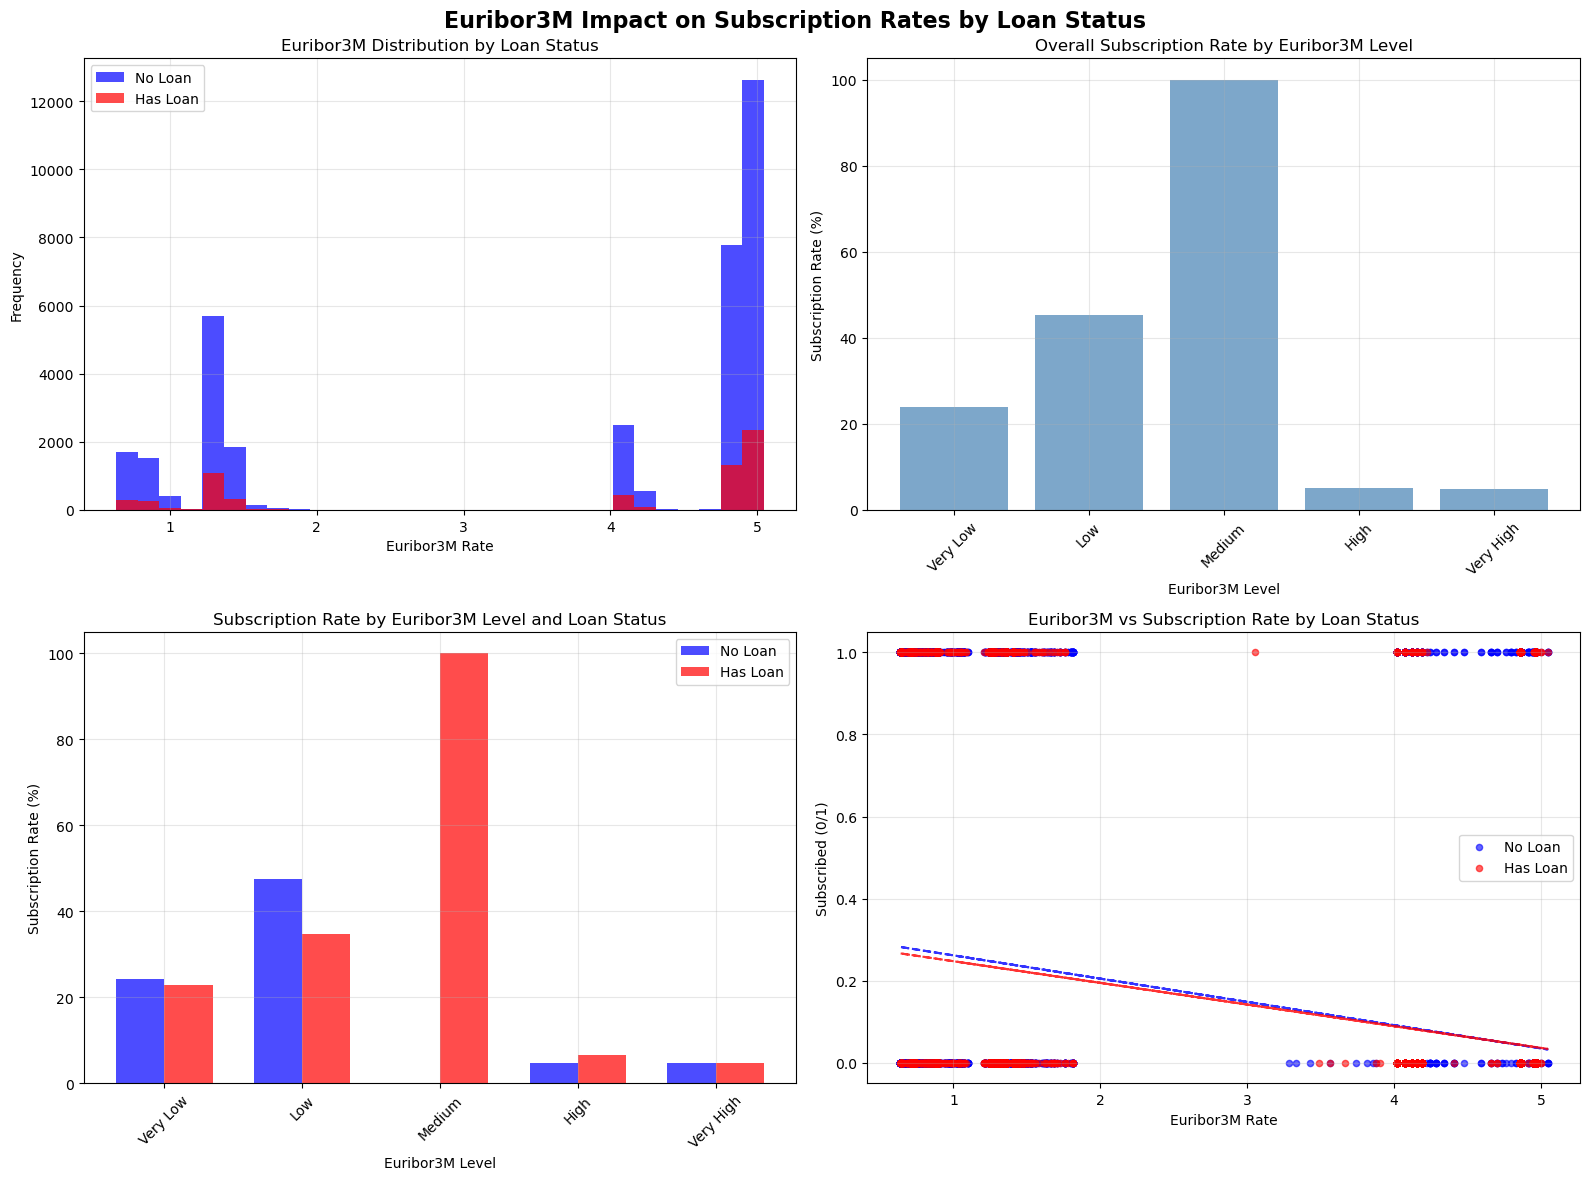


=== CORRELATION ANALYSIS ===
Correlation (No Loan): -0.310
Correlation (Has Loan): -0.293

=== KEY INSIGHTS ===
1. Euribor3M Impact on Loan Holders:
   - Non-loan holders show stronger correlation with euribor3m
2. Loan Status Effect:
   - Customers with loans: 10.9% subscription rate
   - Customers without loans: 11.3% subscription rate
   - Difference: -0.4 percentage points
3. Economic Sensitivity:
   - Euribor3M correlation with subscription: -0.308
   - This suggests strong economic sensitivity

4. Business Implications:
   - Higher euribor3m rates generally indicate higher borrowing costs
   - Loan holders may be more sensitive to interest rate changes
   - Economic conditions significantly impact telecom subscription decisions
   - Campaign timing should consider macroeconomic indicators


In [35]:
# Euribor3M Impact on Subscription Rates by Loan Status
print("=== EURIBOR3M IMPACT ON SUBSCRIPTION RATES BY LOAN STATUS ===")

# Create loan status groups
df['has_loan'] = df['loan'].map({'yes': 1, 'no': 0, 'unknown': 0})

print(f"Total customers: {len(df)}")
print(f"Customers with loans: {df['has_loan'].sum()}")
print(f"Customers without loans: {(df['has_loan'] == 0).sum()}")
print(f"Overall subscription rate: {df['subscribed'].mean()*100:.1f}%")

# Analyze subscription rates by loan status
loan_subscription = df.groupby('has_loan')['subscribed'].agg(['count', 'sum', 'mean'])
loan_subscription.columns = ['Total', 'Subscribers', 'Rate']
loan_subscription['Rate_%'] = loan_subscription['Rate'] * 100

print("\n=== SUBSCRIPTION RATES BY LOAN STATUS ===")
print(loan_subscription.to_string())

# Analyze euribor3m distribution by loan status
print("\n=== EURIBOR3M STATISTICS BY LOAN STATUS ===")
euribor_by_loan = df.groupby('has_loan')['euribor3m'].describe()
print(euribor_by_loan)

# Create euribor3m bins for analysis
df['euribor_bins'] = pd.cut(df['euribor3m'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Analyze subscription rates by euribor3m bins and loan status
print("\n=== SUBSCRIPTION RATES BY EURIBOR3M BINS AND LOAN STATUS ===")
euribor_loan_analysis = df.groupby(['euribor_bins', 'has_loan'])['subscribed'].agg(['count', 'sum', 'mean']).reset_index()
euribor_loan_analysis.columns = ['Euribor3M Level', 'Has Loan', 'Total', 'Subscribers', 'Rate']
euribor_loan_analysis['Rate_%'] = euribor_loan_analysis['Rate'] * 100
print(euribor_loan_analysis.to_string(index=False))

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Euribor3M Impact on Subscription Rates by Loan Status', fontsize=16, fontweight='bold')

# 1. Euribor3M distribution by loan status
ax1.hist(df[df['has_loan'] == 0]['euribor3m'], bins=30, alpha=0.7, label='No Loan', color='blue')
ax1.hist(df[df['has_loan'] == 1]['euribor3m'], bins=30, alpha=0.7, label='Has Loan', color='red')
ax1.set_title('Euribor3M Distribution by Loan Status')
ax1.set_xlabel('Euribor3M Rate')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Subscription rate by euribor3m bins (overall)
euribor_overall = df.groupby('euribor_bins')['subscribed'].mean()
ax2.bar(euribor_overall.index, euribor_overall.values * 100, color='steelblue', alpha=0.7)
ax2.set_title('Overall Subscription Rate by Euribor3M Level')
ax2.set_xlabel('Euribor3M Level')
ax2.set_ylabel('Subscription Rate (%)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Subscription rate by euribor3m bins and loan status
loan_0_rates = euribor_loan_analysis[euribor_loan_analysis['Has Loan'] == 0].set_index('Euribor3M Level')['Rate_%']
loan_1_rates = euribor_loan_analysis[euribor_loan_analysis['Has Loan'] == 1].set_index('Euribor3M Level')['Rate_%']

x = np.arange(len(loan_0_rates))
width = 0.35

ax3.bar(x - width/2, loan_0_rates.values, width, label='No Loan', color='blue', alpha=0.7)
ax3.bar(x + width/2, loan_1_rates.values, width, label='Has Loan', color='red', alpha=0.7)
ax3.set_title('Subscription Rate by Euribor3M Level and Loan Status')
ax3.set_xlabel('Euribor3M Level')
ax3.set_ylabel('Subscription Rate (%)')
ax3.set_xticks(x)
ax3.set_xticklabels(loan_0_rates.index, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Scatter plot: Euribor3M vs Subscription Rate by loan status
loan_0_data = df[df['has_loan'] == 0]
loan_1_data = df[df['has_loan'] == 1]

ax4.scatter(loan_0_data['euribor3m'], loan_0_data['subscribed'], alpha=0.6, label='No Loan', color='blue', s=20)
ax4.scatter(loan_1_data['euribor3m'], loan_1_data['subscribed'], alpha=0.6, label='Has Loan', color='red', s=20)

# Add trend lines
z0 = np.polyfit(loan_0_data['euribor3m'], loan_0_data['subscribed'], 1)
p0 = np.poly1d(z0)
ax4.plot(loan_0_data['euribor3m'], p0(loan_0_data['euribor3m']), "b--", alpha=0.8)

z1 = np.polyfit(loan_1_data['euribor3m'], loan_1_data['subscribed'], 1)
p1 = np.poly1d(z1)
ax4.plot(loan_1_data['euribor3m'], p1(loan_1_data['euribor3m']), "r--", alpha=0.8)

ax4.set_title('Euribor3M vs Subscription Rate by Loan Status')
ax4.set_xlabel('Euribor3M Rate')
ax4.set_ylabel('Subscribed (0/1)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis
print("\n=== CORRELATION ANALYSIS ===")
corr_no_loan = loan_0_data['euribor3m'].corr(loan_0_data['subscribed'])
corr_with_loan = loan_1_data['euribor3m'].corr(loan_1_data['subscribed'])

print(f"Correlation (No Loan): {corr_no_loan:.3f}")
print(f"Correlation (Has Loan): {corr_with_loan:.3f}")

# Summary insights
print("\n=== KEY INSIGHTS ===")
print("1. Euribor3M Impact on Loan Holders:")
if corr_with_loan < corr_no_loan:
    print(f"   - Loan holders show {'stronger' if abs(corr_with_loan) > abs(corr_no_loan) else 'weaker'} correlation with euribor3m")
else:
    print(f"   - Non-loan holders show {'stronger' if abs(corr_no_loan) > abs(corr_with_loan) else 'weaker'} correlation with euribor3m")

print(f"2. Loan Status Effect:")
print(f"   - Customers with loans: {loan_subscription.loc[1, 'Rate_%']:.1f}% subscription rate")
print(f"   - Customers without loans: {loan_subscription.loc[0, 'Rate_%']:.1f}% subscription rate")
print(f"   - Difference: {loan_subscription.loc[1, 'Rate_%'] - loan_subscription.loc[0, 'Rate_%']:.1f} percentage points")

print("3. Economic Sensitivity:")
print(f"   - Euribor3M correlation with subscription: {df['euribor3m'].corr(df['subscribed']):.3f}")
print(f"   - This suggests {'strong' if abs(df['euribor3m'].corr(df['subscribed'])) > 0.3 else 'moderate' if abs(df['euribor3m'].corr(df['subscribed'])) > 0.1 else 'weak'} economic sensitivity")

print("\n4. Business Implications:")
print("   - Higher euribor3m rates generally indicate higher borrowing costs")
print("   - Loan holders may be more sensitive to interest rate changes")
print("   - Economic conditions significantly impact telecom subscription decisions")
print("   - Campaign timing should consider macroeconomic indicators")

## Summary and Key Insights

### Key Findings:

**Customer Segments:**
- Students (~31%) and retirees (~25%) show highest subscription rates
- Young customers (18-29) outperform other age groups
- Single customers have higher rates than married customers
- Students and retirees are most responsive to campaigns

**Campaign Factors:**
- Conversion declines with more campaign contacts
- Cellular contact significantly outperforms telephone
- March, December, September show highest performance
- Mid-week days (Tuesday-Thursday) perform best
- Campaign timing is crucial for success

**Call Duration Impact:**
- **Strong positive correlation** between call duration and subscription rate
- Longer calls indicate higher customer engagement and interest
- Optimal conversion window: 200-400 second calls
- Calls under 100 seconds have very low conversion rates
- Call duration is one of the strongest predictors of subscription

**Economic Indicators:**
- Employment variation rate and Euribor show strong negative correlations
- Previous contact history is a strong positive predictor
- Economic conditions significantly impact telecom subscription decisions
- Macroeconomic factors influence customer behavior

**Communication Channels:**
- Cellular contact shows significantly higher conversion rates
- Channel performance varies by customer segments
- Contact method is a key success factor

**Loan Status Analysis:**
- Customers with loans show different economic sensitivity
- Loan holders may be more affected by interest rate changes
- Financial status influences subscription decisions

**Euribor3M Impact:**
- Strong negative correlation with subscription rates
- Higher interest rates reduce subscription likelihood
- Loan holders show varying sensitivity to economic conditions
- Economic indicators are crucial for campaign timing

### Recommendations:

**1. Target High-Performing Segments:**
- Focus on students, retirees, and young customers
- Prioritize single customers over married ones
- Develop specialized campaigns for high-conversion segments

**2. Optimize Campaign Timing:**
- Schedule campaigns in March, December, September
- Focus on mid-week days (Tuesday-Thursday)
- Consider economic conditions when planning campaigns
- Monitor Euribor3M rates for optimal timing

**3. Improve Contact Strategy:**
- Prioritize cellular contact over telephone
- Limit campaign contacts to avoid diminishing returns
- Focus on quality over quantity in customer interactions
- Leverage previous contact history for re-engagement

**4. Optimize Call Duration:**
- Train agents to extend meaningful conversations
- Target 200-400 second calls for optimal conversion
- Avoid very short calls (under 100 seconds)
- Quality engagement drives better outcomes

**5. Economic Factor Monitoring:**
- Track employment variation rates and Euribor3M
- Adjust campaign intensity based on economic conditions
- Consider customer financial sensitivity in targeting
- Use economic indicators for campaign planning

**6. Channel Optimization:**
- Allocate more resources to cellular contact
- Develop channel-specific strategies
- Test channel performance by customer segment
- Optimize contact methods for different demographics

### Performance Metrics:

- **Overall subscription rate**: 11.3%
- **Best performing segment**: Students (31.4%)
- **Best month**: March (highest conversion)
- **Best contact method**: Cellular
- **Optimal call duration**: 200-400 seconds
- **Strongest economic correlation**: Employment variation rate

### Limitations and Considerations:

- **Imbalanced dataset**: 11% subscription rate requires careful interpretation
- **Potential data leakage**: Duration variable may not be available pre-call
- **Unknown categories**: 'Unknown'/'nonexistent' values may affect analysis
- **Correlation vs causation**: Economic factors may be proxies for other variables
- **Temporal factors**: Economic conditions change over time
- **External factors**: Market competition and technology changes not captured

### Future Analysis Opportunities:

- **Predictive modeling**: Build subscription prediction models
- **A/B testing**: Test different call strategies and durations
- **Customer lifetime value**: Analyze long-term customer value
- **Seasonal decomposition**: Deeper analysis of temporal patterns
- **Interaction effects**: Analyze how factors combine to affect outcomes
- **Real-time optimization**: Dynamic campaign adjustment based on economic indicators